In [1]:
import numpy as np
import cupy as cp
from holotomocupy.utils import *
import sys
import pandas as pd



astropy module not found
olefile module not found


In [ ]:
# prb_opt = sys.argv[1]=='True'
# pos_opt = sys.argv[2]=='True'
# noise = sys.argv[3]=='True'
# method = sys.argv[4]
# niter = int(sys.argv[5])
# gpu = int(sys.argv[6])

prb_opt = True
pos_opt = True
noise = False
method = 'cg'
niter = 4096
gpu = 0
cp.cuda.Device(gpu).use()

cpag = 5e-3
show = True

flg = f'{method}_True_{prb_opt}_{pos_opt}_{noise}'

n = 1024  # object size in each dimension
pad = 0 # pad for the reconstructed probe
npos = 16 # total number of positions
z1 = 4.267e-3 # [m] position of the sample
detector_pixelsize = 3.0e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.24e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
z2 = focusToDetectorDistance-z1
distance = (z1*z2)/focusToDetectorDistance
magnification = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnification)  # object voxel size

extra = 8
nobj = n+n//8
nprb = n+2*pad
npatch = nprb+2*extra

path = f'/data/vnikitin/paper/near_field'
path_out = f'/data/vnikitin/paper/near_field/rec0'
print(f'{voxelsize=},{distance=}')


voxelsize=np.float64(1.000078125e-08),distance=0.00425277555546875


In [3]:
def Lop(psi):
    # fx = cp.fft.fftfreq(2*nprb, d=voxelsize).astype('float32')
    fx = cp.fft.fftfreq(nprb, d=voxelsize).astype('float32')
    [fx, fy] = cp.meshgrid(fx, fx)
    fP = cp.exp(-1j*cp.pi*wavelength*distance*(fx**2+fy**2))
    ff=psi.copy()
    # ff = cp.pad(psi,((0,0),(nprb//2,nprb//2),(nprb//2,nprb//2)))
    ff = cp.fft.ifft2(cp.fft.fft2(ff)*fP)
    # ff = ff[:,nprb//2:-nprb//2,nprb//2:-nprb//2]
    ff = ff[:,pad:nprb-pad,pad:nprb-pad]
    return ff

def LTop(psi):
    # fx = cp.fft.fftfreq(2*nprb, d=voxelsize).astype('float32')
    fx = cp.fft.fftfreq(nprb, d=voxelsize).astype('float32')
    [fx, fy] = cp.meshgrid(fx, fx)
    fP = cp.exp(1j*cp.pi*wavelength*distance*(fx**2+fy**2))
    ff = cp.pad(psi,((0,0),(pad,pad),(pad,pad)))    
    # ff = cp.pad(ff,((0,0),(nprb//2,nprb//2),(nprb//2,nprb//2)))
    ff = cp.fft.ifft2(cp.fft.fft2(ff)*fP)
    # ff = ff[:,nprb//2:-nprb//2,nprb//2:-nprb//2]
    return ff

def Ex(psi,ix):
    res = cp.empty([ix.shape[0],npatch,npatch],dtype='complex64')
    stx = nobj//2-ix[:,1]-npatch//2
    endx = stx+npatch
    sty = nobj//2-ix[:,0]-npatch//2
    endy = sty+npatch
    for k in range(len(stx)):
        res[k] = psi[sty[k]:endy[k],stx[k]:endx[k]] 
    return res

def ExT(psi,psir,ix):
    stx = nobj//2-ix[:,1]-npatch//2
    endx = stx+npatch
    sty = nobj//2-ix[:,0]-npatch//2
    endy = sty+npatch
    for k in range(len(stx)):
        psi[sty[k]:endy[k],stx[k]:endx[k]] += psir[k]
    return psi

def S(psi,p):
    res = cp.pad(psi, ((0, 0), (npatch//2, npatch//2), (npatch//2, npatch//2)),'constant')
    x = cp.fft.fftfreq(2*npatch).astype('float32')
    [y, x] = cp.meshgrid(x, x)
    pp = cp.exp(-2*cp.pi*1j * (y*p[:, 1, None, None]+x*p[:, 0, None, None])).astype('complex64')
    res = cp.fft.ifft2(pp*cp.fft.fft2(res))
    res = res[:, npatch//2:-npatch//2, npatch//2:-npatch//2]    
    return res

def Sop(psi,ix,x,ex):
    data = cp.zeros([x.shape[1], nprb, nprb], dtype='complex64')
    psir = Ex(psi,ix)     
    psir = S(psir,x)
    data = psir[:, ex:npatch-ex, ex:npatch-ex]
    return data

def STop(d,ix,x,ex):
    psi = cp.zeros([nobj, nobj], dtype='complex64')
    dr = cp.pad(d, ((0, 0), (ex, ex), (ex, ex)))
    dr = S(dr,-x)        
    ExT(psi,dr,ix)
    return psi

# adjoint tests
arr1 = (cp.random.random([nobj,nobj])+1j*cp.random.random([nobj,nobj])).astype('complex64')
shifts_test = cp.array((cp.random.random([npos,2])-0.5).astype('float32'))
ishifts = shifts_test.astype('int32')
fshifts = shifts_test-ishifts

arr2 = Sop(arr1,ishifts,fshifts,extra)
arr3 = STop(arr2,ishifts,fshifts,extra)

print(f'{cp.sum(arr1*cp.conj(arr3))}==\n{cp.sum(arr2*cp.conj(arr2))}')

arr1 = (cp.random.random([npos,nprb,nprb])+1j*cp.random.random([npos,nprb,nprb])).astype('complex64')
arr2 = Lop(arr1)
arr3 = LTop(arr2)
print(f'{cp.sum(arr1*cp.conj(arr3))}==\n{cp.sum(arr2*cp.conj(arr2))}')




(11183204+0.13705766201019287j)==
(11183205+9.856229553406592e-06j)
(11186176+0.062181442975997925j)==
(11186176+2.3312884877668694e-05j)


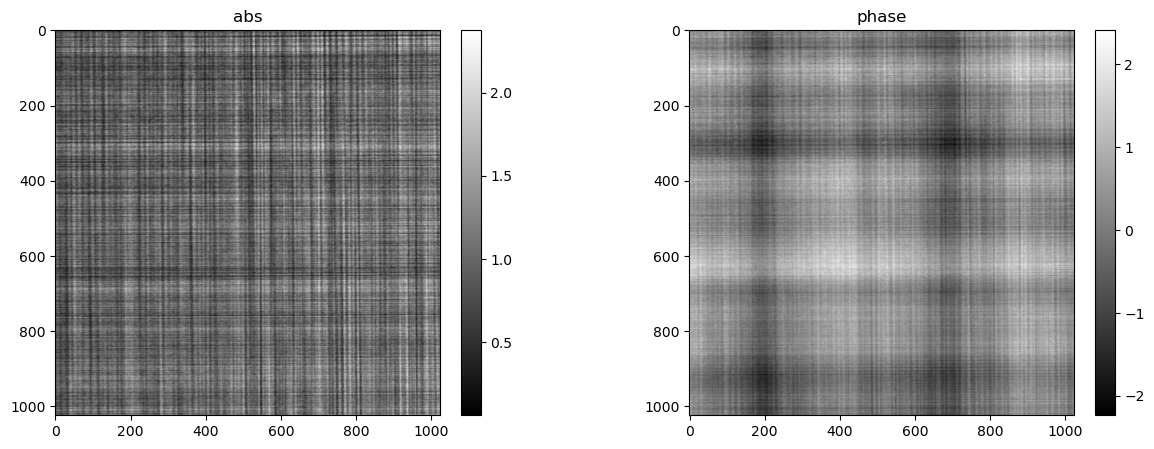

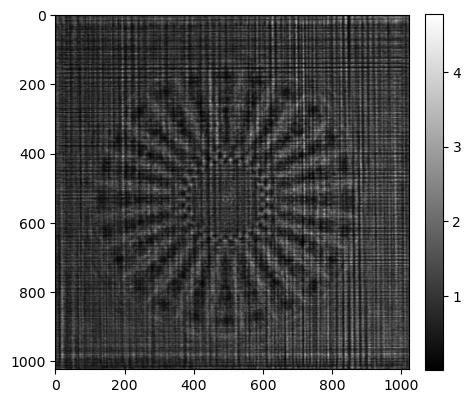

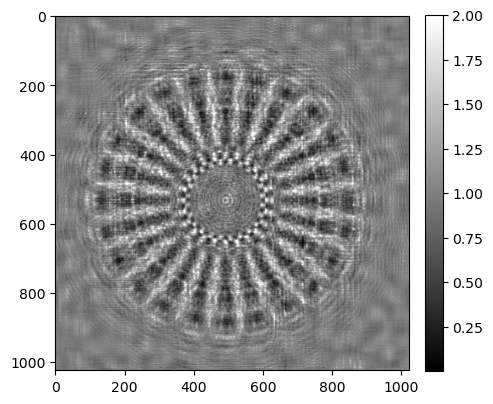

In [4]:
shifts = np.load(f'{path}/data/gen_shifts.npy')[:npos]
shifts_random = np.load(f'{path}/data/gen_shifts_random.npy')[:npos]
prb = np.load(f'{path}/data/gen_prb.npy')
if noise:
    data = np.load(f'{path}/data/ndata.npy')[:npos]
else:
    data = np.load(f'{path}/data/data.npy')[:npos]
ref = np.load(f'{path}/data/ref.npy')
psi = np.load(f'{path}/data/psi.npy')

mshow_polar(prb,show)
mshow(data[0],show)
mshow(data[0]/ref,show,vmax=2)

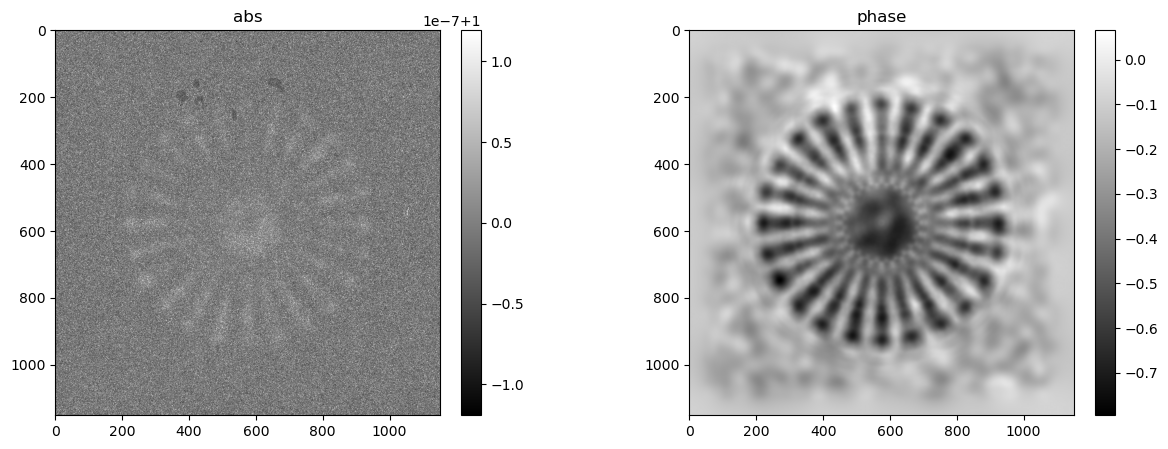

In [5]:
def multiPaganin(data, distances, wavelength, voxelsize, delta_beta,  alpha):
    fx = cp.fft.fftfreq(data.shape[-1], d=voxelsize).astype('float32')
    [fx, fy] = cp.meshgrid(fx, fx)
    numerator = 0
    denominator = 0
    rad_freq = cp.fft.fft2(data)
    taylorExp = 1 + wavelength * distance * cp.pi * (delta_beta) * (fx**2+fy**2)
    numerator = numerator + taylorExp * (rad_freq)
    denominator = denominator + taylorExp**2
    denominator = denominator + alpha
    phase = cp.log(cp.real(cp.fft.ifft2(numerator / denominator)))
    phase = (delta_beta) * 0.5 * phase
    return phase

def rec_init(rdata,ishifts,fshifts,extra):
    recMultiPaganin = cp.zeros([nobj,nobj],dtype='float32')
    recMultiPaganinr = cp.zeros([nobj,nobj],dtype='float32')# to compensate for overlap
    for j in range(0,npos):
        r = rdata[j]        
        rr = r*0+1 # to compensate for overlap
                
        rpsi = cp.ones([nobj,nobj],dtype='float32')
        rrpsi = cp.ones([nobj,nobj],dtype='float32')
        stx = nobj//2-ishifts[j,1]-n//2
        endx = stx+n
        sty = nobj//2-ishifts[j,0]-n//2
        endy = sty+n
        rpsi[sty:endy,stx:endx] = r
        rrpsi[sty:endy,stx:endx] = rr

        rpsi = multiPaganin(rpsi,distance, wavelength, voxelsize,  24.05, cpag)
        # mshow(rpsi,True)
        # ss
        recMultiPaganin += rpsi
        recMultiPaganinr += rrpsi
        
    recMultiPaganinr[np.abs(recMultiPaganinr)<5e-2] = 1    
    # compensate for overlap
    recMultiPaganin /= recMultiPaganinr    
    recMultiPaganin = np.exp(1j*recMultiPaganin)
    return recMultiPaganin

shifts = cp.array(shifts)
ishifts = cp.round(shifts).astype('int32')
fshifts = shifts-ishifts

rdata = cp.array(data/(ref+1e-5))
rec_paganin = rec_init(rdata,ishifts,fshifts,extra)
# rec_paganin[256:256+32,200:200+64]=cp.exp(-1j)
mshow_polar(rec_paganin,show)
np.save(f'{path}/data/paganin',rec_paganin.get())


##### $$\nabla F=2 \left(L^*\left( L(M(q_0,\psi_0,\boldsymbol{x}_0))-\tilde d\right)\right).$$
##### where $$\tilde d = d \frac{L(M(q_0,\psi_0,\boldsymbol{x}_0))}{|L(M(q_0,\psi_0,\boldsymbol{x}_0))|}$$




In [6]:
def gradientF(vars, pars, d):
    (q,psi,x) = (vars['prb'], vars['psi'], vars['fshift'])
    (ix,ex) = (pars['ishift'],pars['extra'])
    # dd = Sop(psi,ix,x,ex)
    # ddd = np.load('/home/beams8/TOMO/vnikitin/holotomocupy/paper/near_field/patches.npy')
    # print(ix)
    # mshow_polar(ddd[0,0],True)
    # mshow_polar(dd[0].get()-ddd[0,0],True)    
    Lpsi = Lop(Sop(psi,ix,x,ex)*q)
    if pars['model']=='Gaussian':
        td = d*(Lpsi/(np.abs(Lpsi)+pars['eps']))        
        res = 2*LTop(Lpsi - td)        
    else:        
        # d0n = d/(cp.abs(Lpsi)+pars['eps']) 
        # psi0p = Lpsi/(cp.abs(Lpsi)+pars['eps'])    
        dd = d*Lpsi/(cp.abs(Lpsi)**2+pars['eps']**2) 
        res = 2*LTop(Lpsi-dd)               
    return res

##### $$\nabla_{\psi} G|_{(q_0,\psi_0,\boldsymbol{x}_0)}= S_{\boldsymbol{x}_{0}}^*\left(\overline{J(q_0)}\cdot \nabla F\right)$$

##### $$\nabla_{q} G|_{(q_0,\psi_0,\boldsymbol{x}_0)}=J^*\left( \overline{S_{\boldsymbol{x}_{0}}(C_f^*(\psi_0)+\psi_{fr})}\cdot \nabla F\right).$$
##### $$\nabla_{\boldsymbol{x}_0} G|_{(q_0,\psi_0,\boldsymbol{x}_0)}=\textsf{Re}\Big(\big( \Big\langle \overline{q_0}\cdot \nabla F,   C(\mathcal{F}^{-1}(-2\pi i \xi_1 e^{ -2\pi i \boldsymbol{x}_{0,k}\cdot \boldsymbol{\xi}}\hat{\psi_0}))\Big\rangle,\Big\langle \overline{q_0}\cdot \nabla F,C(\mathcal{F}^{-1}(-2\pi i \xi_2 e^{ -2\pi i \boldsymbol{x}_{0,k}\cdot \boldsymbol{\xi}}\hat{\psi_0})) \Big\rangle\big)\Big)_{k=1}^K. $$




In [7]:
def gradient_psi(q,ix,x,ex,gradF):
    return STop(np.conj(q)*gradF,ix,x,ex)

def gradient_prb(psi,ix,x,ex,gradF):
    return np.sum(np.conj(Sop(psi,ix,x,ex))*gradF,axis=0)

def Sw(psi,p,w):
    res = cp.pad(psi, ((0, 0), (npatch//2, npatch//2), (npatch//2, npatch//2)),'constant')
    x = cp.fft.fftfreq(2*npatch).astype('float32')
    [y, x] = cp.meshgrid(x, x)
    w = w*cp.exp(-2*cp.pi*1j * (y*p[:, 1, None, None]+x*p[:, 0, None, None]))
    res[:] = cp.fft.fft2(res)
    res *= w
    res[:] = cp.fft.ifft2(res)
    res = res[:, npatch//2:-npatch//2, npatch//2:-npatch//2]  
    return res

def gradient_shift(psi,q,ix,x,ex,gradF):
    gradx = cp.zeros([npos,2],dtype='float32')    

    xi1 = cp.fft.fftfreq(2*npatch).astype('float32')
    [xi2, xi1] = cp.meshgrid(xi1, xi1)
    
    psir = Ex(psi,ix)                
    psir = Sw(psir,x,xi1)[:,ex:npatch-ex,ex:npatch-ex]
    gradx[:,0] = -2*np.pi*imdot(gradF,q*psir,axis=(1,2))    
    
    psir = Ex(psi,ix)                
    psir = Sw(psir,x,xi2)[:,ex:npatch-ex,ex:npatch-ex]
    gradx[:,1] = -2*np.pi*imdot(gradF,q*psir,axis=(1,2))        
    return gradx

def gradients(vars,pars,gradF):
    (q,psi,x) = (vars['prb'], vars['psi'], vars['fshift'])
    (ix,ex,rho) = (pars['ishift'],pars['extra'],pars['rho'])

    grads = {}    
    grads['psi'] = rho[0]*gradient_psi(q,ix,x,ex,gradF)
    grads['prb'] = rho[1]*gradient_prb(psi,ix,x,ex,gradF)
    grads['fshift'] = rho[2]*gradient_shift(psi,q,ix,x,ex,gradF)

    return grads

##### $$\frac{1}{2}\mathcal{H}|_{x_0}(y,z)= \left\langle \mathbf{1}-d_{0}, \mathsf{Re}({L(y)}\overline{L(z)})\right\rangle+\left\langle d_{0},(\mathsf{Re} (\overline{l_0}\cdot L(y)))\cdot (\mathsf{Re} (\overline{l_0}\cdot L(z))) \right\rangle$$
##### $$l_0=L(x_0)/|L(x_0)|$$
##### $$d_0=d/|L(x_0)|$$


In [8]:
def hessianF(Lm,Ldm1,Ldm2,data,pars):
    if pars['model']=='Gaussian':
        psi0p = Lm/(np.abs(Lm)+pars['eps'])
        d0 = data/(np.abs(Lm)+pars['eps'])
        v1 = np.sum((1-d0)*reprod(Ldm1,Ldm2))
        v2 = np.sum(d0*reprod(psi0p,Ldm1)*reprod(psi0p,Ldm2))        
    else:        
        psi0p = Lm/(cp.abs(Lm)+pars['eps'])            
        v1 = cp.sum((1-data/(cp.abs(Lm)**2+pars['eps']**2))*reprod(Ldm1,Ldm2))
        v2 = 2*cp.sum(data*reprod(psi0p,Ldm1)*reprod(psi0p,Ldm2)/(cp.abs(Lm)**2+pars['eps']**2))
    return 2*(v1+v2)

##### $D T_\psi|_{{{z}_0}}(\Delta {z})=-2\pi iC\Big(\mathcal{F}^{-1}\big({\Delta z \cdot \xi}) e^{-2\pi i  {z}_0\cdot {\xi}}\hat{\psi}({\xi})\big)\Big)=-2\pi i C\Big(\mathcal{F}^{-1}\big((\Delta z_1 {\xi_1}+\Delta z_2 {\xi_2}) e^{-2\pi i  {z}_0\cdot {\xi}}\hat{\psi}({\xi})\big)\Big)$
##### $ D^2{T_\psi}|_{{{z}_0}}(\Delta{z},\Delta{w})=-4\pi^2C(\mathcal{F}^{-1}((\Delta{z}\cdot\xi)(\Delta{w}\cdot\xi)e^{-2\pi i  {z}_0\cdot {\xi}}\hat{\psi}))$
##### $=-4\pi^2C(\mathcal{F}^{-1}((\Delta{z_1}\Delta{w_1}\xi_1^2 + (\Delta{z_1}\Delta{w_2}+\Delta{z_2}\Delta{w_1})\xi_1\xi_2+\Delta{z_2}\Delta{w_2}\xi_2^2)\hat{\psi}))$

In [9]:
def DT(psi,ix,x,ex,dx):
    res = cp.zeros([npos,nprb,nprb],dtype='complex64')
    xi1 = cp.fft.fftfreq(2*npatch).astype('float32')    
    [xi2, xi1] = cp.meshgrid(xi1, xi1)

    psir = Ex(psi,ix)
    dx = dx[:,:,np.newaxis,np.newaxis]
    w = xi1*dx[:,0]+xi2*dx[:,1]
    psir = Sw(psir,x,w)[:,ex:npatch-ex,ex:npatch-ex]
    res = -2*np.pi*1j*psir
    return res

def D2T(psi,ix,x,ex,dx1,dx2):
    res = cp.zeros([npos,nprb,nprb],dtype='complex64')
    xi1 = cp.fft.fftfreq(2*npatch).astype('float32')
    [xi2, xi1] = cp.meshgrid(xi1, xi1)
    psir = Ex(psi,ix)
    dx1 = dx1[:,:,np.newaxis,np.newaxis]
    dx2 = dx2[:,:,np.newaxis,np.newaxis]
    w = xi1**2*dx1[:,0]*dx2[:,0]+ \
                xi1*xi2*(dx1[:,0]*dx2[:,1]+dx1[:,1]*dx2[:,0])+ \
                xi2**2*dx1[:,1]*dx2[:,1]
    psir = Sw(psir,x,w)[:,ex:npatch-ex,ex:npatch-ex]
    res = -4*np.pi**2*psir
    return res    

#### $$ DM|_{(q_0,\psi_0,\boldsymbol{x})}(\Delta q, \Delta \psi,\Delta\boldsymbol{x})=$$
#### $$ \Big(\Delta q\cdot T_{\psi_0}({\boldsymbol{x}_{0,k}})+ q_0\cdot \big(T_{\Delta \psi}({\boldsymbol{x}_{0,k}})+  DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}_k)\big) \Big)_{k=1}^K=$$
#### $$ J(\Delta q)\cdot S_{\boldsymbol{x}_{0,k}}(\psi_0)+ J(q_0)\cdot S_{\boldsymbol{x}_{0}}{(\Delta \psi)}+  \Big(q_0\cdot DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}_k) \Big)_{k=1}^K$$


In [10]:
def DM(psi,q,ix,x,ex,dpsi,dq,dx):
    res = dq*Sop(psi,ix,x,ex)+q*(Sop(dpsi,ix,x,ex)+DT(psi,ix,x,ex,dx))   
    return res

##### $$ D^2M|_{(q_0,\psi_0,\boldsymbol{x})}\big((\Delta q^{(1)}, \Delta \psi^{(1)},\Delta\boldsymbol{x}^{(1)}),(\Delta q^{(2)}, \Delta \psi^{(2)},\Delta\boldsymbol{x}^{(2)})\big)= $$
##### $$\Big( q_0\cdot DT_{\Delta\psi^{(1)}}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(2)})+q_0\cdot DT_{\Delta\psi^{(2)}}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(1)})+ q_0\cdot D^2{T_\psi}|_{{\boldsymbol{x}_0}}(\Delta\boldsymbol{x}^{(1)},\Delta\boldsymbol{x}^{(2)})+$$
##### $$\Delta q^{(1)}\cdot T_{\Delta \psi^{(2)}}({\boldsymbol{x}_{0,k}})+\Delta q^{(2)}\cdot T_{\Delta \psi^{(1)}}({\boldsymbol{x}_{0,k}})+ $$
##### $$\Delta q^{(1)}\cdot DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(2)})+\Delta q^{(2)}\cdot DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(1)})\Big)_{k=1}^K.$$


In [11]:
def D2M(psi,q,ix,x,ex,dpsi1,dq1,dx1,dpsi2,dq2,dx2):    
    # print(q.shape,DT(dpsi1,ix,x,ex,dx2).shape,D2T(psi,ix,x,ex,dx1,dx2).shape)
    res =  q*DT(dpsi1,ix,x,ex,dx2) + q*DT(dpsi2,ix,x,ex,dx1) + q*D2T(psi,ix,x,ex,dx1,dx2)  
    res += dq1*Sop(dpsi2,ix,x,ex) + dq2*Sop(dpsi1,ix,x,ex) 
    res += dq1*DT(psi,ix,x,ex,dx2) + dq2*DT(psi,ix,x,ex,dx1)
    return res

##### $$\mathcal{H}^G|_{ (q_0,\psi_0,\boldsymbol{x}_0)}\Big((\Delta q^{(1)},\Delta \psi^{(1)},\Delta \boldsymbol{x}^{(1)}),(\Delta q^{(2)},\Delta \psi^{(2)},\Delta \boldsymbol{x}^{(2)})\Big)=$$
##### $$\Big\langle \nabla F|_{M(q_0,\psi_0,\boldsymbol{x}_0)}, D^2M|_{(q_0,\psi_0,\boldsymbol{x}_0)}\Big((\Delta q^{(1)},\Delta \psi^{(1)},\Delta \boldsymbol{x}^{(1)}),(\Delta q^{(2)},\Delta \psi^{(2)},\Delta \boldsymbol{x}^{(2)})\Big)\Big\rangle +$$
##### $$\mathcal{H}^F|_{M(q_0,\psi_0,\boldsymbol{x}_0)}\Big(DM|_{(q_0,\psi_0,\boldsymbol{x}_0)}(\Delta q^{(1)},\Delta \psi^{(1)},\Delta \boldsymbol{x}^{(1)}),DM|_{(q_0,\psi_0,\boldsymbol{x}_0)}(\Delta q^{(2)},\Delta \psi^{(2)},\Delta \boldsymbol{x}^{(2)})\Big)$$


### Updates:

\begin{equation}
               \alpha_j=\frac{\mathsf{Re}\langle \nabla F|_{x_j},s_j\rangle}{H|_{x_j}( {s_j},s_j)}
             \end{equation}

\begin{equation}
                \beta_j=\frac{H(\nabla F|_{x_j},s_j)}{H|_{x_j}( {s_j},s_j)}.
\end{equation}

### Scaling variables:

\begin{equation}
\begin{aligned}
\tilde{\beta}_j=\frac{H^{\tilde{F}}|_{\tilde{x}_j} (\nabla \tilde{F}|_{\tilde{x}_j},\tilde{\eta}_j)}{H^{\tilde{F}}|_{\tilde{x}_j} (\tilde{\eta}_j,\tilde{\eta}_j)}=\frac{H^{F}|_{x_j} (\rho\nabla \tilde{F}|_{\tilde{x}_j},\rho\tilde{\eta}_j)}{H^{F}|_{x_j} (\rho\tilde{\eta}_j,\rho\tilde{\eta}_j)}=\frac{H^{F}|_{x_j} (\rho^2\nabla F|_{x_j},\rho\tilde{\eta}_j)}{H^{F}|_{x_j} (\rho\tilde{\eta}_j,\rho\tilde{\eta}_j)}
\end{aligned}
\end{equation}

\begin{equation}
\begin{aligned}
\tilde{\alpha}_j=\frac{\langle\nabla \tilde{F}|_{\tilde{x}_j},\tilde{\eta}_j\rangle}{H^{\tilde{F}}|_{\tilde{x}_j} (\tilde{\eta}_j,\tilde{\eta}_j)}=\frac{\langle \rho\nabla F|_{x_j},\tilde{\eta}_j\rangle}{H^{F}|_{x_j} (\rho\tilde{\eta}_j,\rho\tilde{\eta}_j)}
\end{aligned}
\end{equation}

\begin{equation}
    \begin{aligned}
        \tilde{\eta}_{j+1} = -\nabla \tilde{F}|_{\tilde{x}_j}+\tilde{\beta}_j\tilde{\eta}_j=-\rho\nabla F|_{x_j}+\tilde{\beta}_j\tilde{\eta}_j,\quad \text{with } \tilde{\eta}_0=-\rho\nabla F|_{x_0}
    \end{aligned}
\end{equation}

\begin{equation}
    \begin{aligned}
        \tilde{x}_{j+1} = \tilde{x}_{j}+\tilde{\alpha}_j\tilde{\eta}_{j+1}
    \end{aligned}
\end{equation}

Multiplying both sides by $\rho$,

\begin{equation}
    \begin{aligned}
        x_{j+1} = x_j+\rho\tilde{\alpha}_j\tilde{\eta}_{j+1}
    \end{aligned}
\end{equation}

In [12]:
def calc_beta(vars,grads,etas,pars,d,gradF):
    (q,psi,x) = (vars['prb'], vars['psi'], vars['fshift'])    
    (ix,ex,rho) = (pars['ishift'],pars['extra'],pars['rho'])
    # scaled with rho
    (dpsi1,dq1,dx1) = (grads['psi']*rho[0], grads['prb']*rho[1], grads['fshift']*rho[2])
    (dpsi2,dq2,dx2) = (etas['psi']*rho[0], etas['prb']*rho[1], etas['fshift']*rho[2])
    
    # beta = top/bottom
    top = 0
    bottom = 0
    
    d2m1 = D2M(psi,q,ix,x,ex,dpsi1,dq1,dx1,dpsi2,dq2,dx2)
    top += redot(gradF,d2m1)        
    
    d2m2 = D2M(psi,q,ix,x,ex,dpsi2,dq2,dx2,dpsi2,dq2,dx2)
    bottom += redot(gradF,d2m2)    
    
    Lm = Lop(Sop(psi,ix,x,ex)*q)
    Ldm1 = Lop(DM(psi,q,ix,x,ex,dpsi1,dq1,dx1))
    Ldm2 = Lop(DM(psi,q,ix,x,ex,dpsi2,dq2,dx2))        

    top += hessianF(Lm, Ldm1, Ldm2, d, pars)            
    bottom += hessianF(Lm, Ldm2, Ldm2,d, pars)
    
    return top/bottom

def calc_alpha(vars,grads,etas,pars,d,gradF):    
    (q,psi,x) = (vars['prb'], vars['psi'], vars['fshift'])    
    (ix,ex,rho) = (pars['ishift'],pars['extra'],pars['rho'])
    (dpsi1,dq1,dx1) = (grads['psi'], grads['prb'], grads['fshift'])
    (dpsi2,dq2,dx2) = (etas['psi'], etas['prb'], etas['fshift'])    

    # beta = top/bottom    
    top = -redot(dpsi1,dpsi2)-redot(dq1,dq2)-redot(dx1,dx2)
    
    # scale variable for the hessian
    (dpsi2,dq2,dx2) = (etas['psi']*rho[0], etas['prb']*rho[1], etas['fshift']*rho[2])
    
    d2m2 = D2M(psi,q,ix,x,ex,dpsi2,dq2,dx2,dpsi2,dq2,dx2)
    bottom = redot(gradF,d2m2)
    
    Lm = Lop(Sop(psi,ix,x,ex)*q)            
    Ldm2 = Lop(DM(psi,q,ix,x,ex,dpsi2,dq2,dx2))

    bottom += hessianF(Lm, Ldm2, Ldm2,d,pars)
    
    return top/bottom, top, bottom

## debug functions

In [13]:
def minf(Lpsi,d,pars):
    if pars['model']=='Gaussian':
        f = cp.linalg.norm(cp.abs(Lpsi)-d)**2
    else:        
        f = cp.sum(cp.abs(Lpsi)**2-2*d*cp.log(cp.abs(Lpsi)+pars['eps']))        
    return f

def plot_debug2(vars,etas,pars,top,bottom,alpha,data):
    '''Check the minimization functional behaviour'''

    if show==False:
        return
    (q,psi,x) = (vars['prb'], vars['psi'], vars['fshift'])    
    (ix,ex,rho) = (pars['ishift'],pars['extra'],pars['rho'])
    (dpsi2,dq2,dx2) = (etas['psi'], etas['prb'], etas['fshift'])    

    npp = 3
    errt = cp.zeros(npp*2)
    errt2 = cp.zeros(npp*2)
    for k in range(0,npp*2):
        psit = psi+(alpha*k/(npp-1))*rho[0]*dpsi2
        qt = q+(alpha*k/(npp-1))*rho[1]*dq2
        xt = x+(alpha*k/(npp-1))*rho[2]*dx2

        errt[k] = minf(Lop(Sop(psit,ix,xt,ex)*qt),data,pars)
                
    t = alpha*(cp.arange(2*npp))/(npp-1)    
    errt2 = minf(Lop(Sop(psi,ix,x,ex)*q),data,pars)
    errt2 = errt2 -top*t+0.5*bottom*t**2
    
    plt.plot(alpha.get()*cp.arange(2*npp).get()/(npp-1),errt.get(),'.')
    plt.plot(alpha.get()*cp.arange(2*npp).get()/(npp-1),errt2.get(),'.')
    plt.show()

def plot_debug3(shifts,shifts_init):
    '''Current errors in shifts'''

    if show==False:
        return
    plt.plot(shifts_init[:,0].get()-(shifts[:,0].get()),'r.')
    plt.plot(shifts_init[:,1].get()-(shifts[:,1].get()),'b.')
    plt.show()

def vis_debug(vars,i):
    '''Visualization and data saving'''

    (q,psi,x) = (vars['prb'], vars['psi'], vars['fshift'])    
    
    mshow_polar(psi,show)
    mshow_polar(psi[nobj//2-n//8:nobj//2+n//8,nobj//2+n//4:nobj//2+n//2],show)
    mshow_polar(q,show)
    dxchange.write_tiff(np.angle(psi).get(),f'{path_out}_{flg}/crec_psi_angle/{i:03}',overwrite=True)
    dxchange.write_tiff(np.abs(psi).get(),f'{path_out}_{flg}/crec_psi_abs/{i:03}',overwrite=True)
    dxchange.write_tiff(np.angle(q).get(),f'{path_out}_{flg}/crec_prb_angle/{i:03}',overwrite=True)
    dxchange.write_tiff(np.abs(q).get(),f'{path_out}_{flg}/crec_prb_abs/{i:03}',overwrite=True)
    np.save(f'{path_out}_{flg}/crec_shift_{i:03}',x)

def minf(Lpsi,d,pars):
    if pars['model']=='Gaussian':
        f = cp.linalg.norm(cp.abs(Lpsi)-d)**2
    else:        
        f = cp.sum(cp.abs(Lpsi)**2-2*d*cp.log(cp.abs(Lpsi)+pars['eps']))        
        # loss = torch.nn.PoissonNLLLoss(log_input=False, full=True, size_average=None, eps=pars['eps'], reduce=None, reduction='sum')
        # f = loss(torch.as_tensor(cp.abs(Lpsi)**2,device='cuda'),torch.as_tensor(d,device='cuda'))
        # print(f,ff)
    return f

def err_debug(vars,pars, data,grads=None):    
    '''Print error'''    
    (q,psi,x) = (vars['prb'], vars['psi'], vars['fshift'])    
    (ix,ex) = (pars['ishift'],pars['extra'])        
    # fpsi = np.abs(Lop(Sop(psi,ix,x,ex)*q))-data
    err = minf(Lop(Sop(psi,ix,x,ex)*q),data,pars)
    print(f'gradient norms (psi, prb, fshift): {np.linalg.norm(grads['psi']):.2f}, {np.linalg.norm(grads['prb']):.2f}, {np.linalg.norm(grads['fshift']):.2f}')                        
    return err

# CG

# GD

In [ ]:
def cg_holo(data, vars, pars):
    if pars['model']=='Gaussian':
        data = cp.sqrt(data)

    erra = cp.zeros(pars['niter'])
    alphaa = cp.zeros(pars['niter'])    
    shifts_init = vars['shift_init'].copy()
    grads = {'psi':0,'prb':0,'fshift':0}
    alpha = 0
    table = pd.DataFrame(columns=["epoch", "loss"])
    table["epoch"] = table["epoch"].astype(int)
    
    for i in range(pars['niter']):                     

        if i % pars['err_step'] == 0 and pars['err_step'] != -1:
            err = err_debug(vars, pars, data, grads)/(n*n*npos)    
            erra[i] = err                        
            alphaa[i] = alpha        
            print(f'{i}) {alphaa[i-1]=}, {pars['rho']} {erra[i]=:1.5e}',flush=True)                        
            table.loc[len(table)] = [i, erra[i].get()]
            table.to_csv(f'fifth_rule_{flg}', index=False)

        if i % pars['vis_step'] == 0 and pars['vis_step'] != -1:
            vis_debug(vars, i)
            if pars['rho'][2]>0:
                plot_debug3(vars['fshift'],shifts_init)      

        gradF = gradientF(vars,pars,data) 
        grads = gradients(vars,pars,gradF)
        if i==0 or method=='gd':
            etas = {}
            etas['psi'] = -grads['psi']
            etas['prb'] = -grads['prb']
            etas['fshift'] = -grads['fshift']
        else:      
            beta = calc_beta(vars, grads, etas, pars, data, gradF)
            etas['psi'] = -grads['psi'] + beta*etas['psi']
            etas['prb'] = -grads['prb'] + beta*etas['prb']
            etas['fshift'] = -grads['fshift'] + beta*etas['fshift']

        alpha,top,bottom = calc_alpha(vars, grads, etas, pars, data, gradF) 
        if i % pars['vis_step'] == 0 and pars['vis_step'] != -1:
            plot_debug2(vars,etas,pars,top,bottom,alpha,data)

        vars['psi'] += pars['rho'][0]*alpha*etas['psi']
        vars['prb'] += pars['rho'][1]*alpha*etas['prb']
        vars['fshift'] += pars['rho'][2]*alpha*etas['fshift']
    return vars,erra,alphaa

if method =='gd':
    rho = [1,1.5,0.1]
else:
    rho = [1,1.5,0.1]
if prb_opt:
    probe = 1+0*prb
else:
    probe = prb
    rho[1] = 0
if pos_opt:
    positions_px = cp.array(shifts_random)
else:
    positions_px = cp.array(shifts)
    rho[2] = 0

vars = {}
vars['psi'] = rec_paganin.copy()
vars['prb'] = cp.array(probe)
vars['shift_init'] = cp.array(positions_px-cp.round(positions_px).astype('int32'))
vars['fshift'] = cp.array(positions_px-cp.round(positions_px).astype('int32'))

pars = {'niter': niter, 'err_step': 1, 'vis_step': -1}
pars['rho'] = rho
pars['ishift'] = cp.round(positions_px).astype('int32')
pars['extra'] = extra
pars['eps'] = 1e-8
pars['model'] = 'Gaussian'

data_rec = cp.array(data).copy()
vars,erra,alphaa = cg_holo(data_rec, vars, pars)           

gradient norms (psi, prb, fshift): 0.00, 0.00, 0.00
0) alphaa[i-1]=array(0.), [1, 1.5, 0.1] erra[i]=5.48559e-02
gradient norms (psi, prb, fshift): 3894.10, 10873.41, 232.39
1) alphaa[i-1]=array(0.), [1, 1.5, 0.1] erra[i]=5.04763e-03
gradient norms (psi, prb, fshift): 1370.03, 1267.37, 222.37
2) alphaa[i-1]=array(0.01253182), [1, 1.5, 0.1] erra[i]=3.42699e-03
gradient norms (psi, prb, fshift): 764.40, 725.77, 205.59
3) alphaa[i-1]=array(0.0153313), [1, 1.5, 0.1] erra[i]=2.86622e-03
gradient norms (psi, prb, fshift): 554.98, 507.77, 170.98
4) alphaa[i-1]=array(0.0164758), [1, 1.5, 0.1] erra[i]=2.60544e-03
gradient norms (psi, prb, fshift): 348.03, 373.10, 149.67
5) alphaa[i-1]=array(0.01455101), [1, 1.5, 0.1] erra[i]=2.45254e-03
gradient norms (psi, prb, fshift): 312.87, 346.83, 124.57
6) alphaa[i-1]=array(0.01832613), [1, 1.5, 0.1] erra[i]=2.35129e-03
gradient norms (psi, prb, fshift): 214.32, 267.84, 110.60
7) alphaa[i-1]=array(0.01439235), [1, 1.5, 0.1] erra[i]=2.27267e-03
gradient no

: 